In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt_bpe'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_bert_base_cased'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'bert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A1', 1: 'A12', 2: 'A7', 3: 'A16', 4: 'A8', 5: 'A22', 6: 'A4', 7: 'A11', 8: 'A14', 9: 'A9', 10: 'A17'}
dict_values(['A1', 'A12', 'A7', 'A16', 'A8', 'A22', 'A4', 'A11', 'A14', 'A9', 'A17'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

1


<All keys matched successfully>

### Data loading

In [7]:
en_test_df = pd.read_csv(pathjoin(DATA_DIR, 'en_topic'))
en_test_df.head()

,Unnamed: 0,target,text,topic
0,0,A4,love ; you will learn from me by luck ; you co...,music
1,1,A4,"playing at home with his shoulders . "" You are...",music
2,2,A4,rock to put and shook her handkerchief away in...,music
3,3,A4,love with him – and he began to think that thi...,music
4,4,A4,"songs . In degrees others . Their armour , daz...",music


In [8]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

11


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.6258992805755396 precision 0.87 recall 0.4887640449438202
label (fictive) f1_score 0.966183574879227 precision 1.0 recall 0.9345794392523364
label (instruct) f1_score 0.8019323671497584 precision 0.83 recall 0.7757009345794392
label (reporting) f1_score 0.8627450980392156 precision 0.88 recall 0.8461538461538461
label (legal) f1_score 0.9253731343283582 precision 0.93 recall 0.9207920792079208
label (personal) f1_score 0.6593406593406594 precision 0.6 recall 0.7317073170731707
label (commercial) f1_score 0.8712871287128714 precision 0.88 recall 0.8627450980392157
label (research) f1_score 0.6923076923076923 precision 0.54 recall 0.9642857142857143
label (info) f1_score 0.6772486772486772 precision 0.64 recall 0.7191011235955056
label (eval) f1_score 0.8235294117647058 precision 0.7 recall 1.0
label (stuff) f1_score 0.8431372549019608 precision 0.86 recall 0.8269230769230769
accuracy 0.7936363636363636


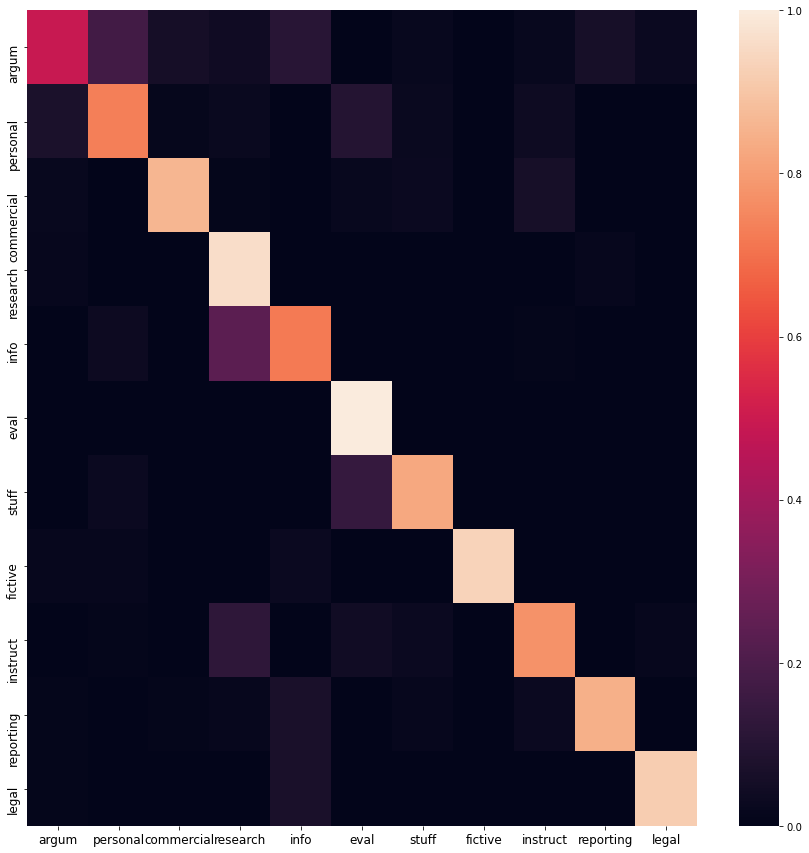

In [14]:
plot_confusion_matrix(predicted_classes, true_classes)

### Topic analysis

In [23]:
def analyze_topics(topic_df, predicted_classes):
    count_by_topic, correct_count_by_topic = dict(), dict()
    
    for item_id, predicted_class in enumerate(predicted_classes):
        topic = topic_df.topic.values[item_id]
        true_class = topic_df.target.values[item_id]
        if topic not in count_by_topic:
            correct_count_by_topic[topic] = count_by_topic[topic] = 0
        count_by_topic[topic] += 1
        correct_count_by_topic[topic] += (predicted_class == true_class)
        
    for topic, count in count_by_topic.items():
        print("topic:", topic)
        print("accuracy:", correct_count_by_topic[topic] / count)

In [24]:
analyze_topics(en_test_df, predicted_classes)

topic: music
accuracy: 0.8363636363636363
topic: education
accuracy: 0.7636363636363637
topic: politics
accuracy: 0.7636363636363637
topic: sport
accuracy: 0.7545454545454545
topic: business
accuracy: 0.7727272727272727
topic: literature
accuracy: 0.7636363636363637
topic: crime
accuracy: 0.7818181818181819
topic: travel
accuracy: 0.7818181818181819
topic: games
accuracy: 0.9
topic: arhitecture
accuracy: 0.8181818181818182
